In [184]:
import sys
import math
from metrics import evaluate_classification
from plots import plot_decision_boundary, plot_data

from sklearn.datasets import make_classification, make_moons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

LAST_NEURON = 1

In [185]:
class NeuralNet:
    def __init__(self, layer_dims, layer_activations, mini_batch_size = 1, keep_prob=1, patience = 100, normalize = True, learning_rate = 0.01, num_epochs = 30000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.normalize = normalize
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.keep_prob = keep_prob
        self.mini_batch_size = mini_batch_size

        self.best_loss = np.inf
        self.patience = patience
        self.epochs_without_improvement = 0

        self.is_cost_binary: bool
        if layer_activations[-1] == 'sigmoid':
            self.is_cost_binary = True
        else:
            self.is_cost_binary = False
    
    def __initialize_parameters(self, layer_dims):
        np.random.seed(42)
        self.parameters={}
        self.grads={}

        L = len(layer_dims)
        for l in range(1, L):
            self.parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
            self.parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

            assert(self.parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
            assert(self.parameters['b' + str(l)].shape == (layer_dims[l], 1))

    def __random_mini_batches(self, X, Y, mini_batch_size=1, seed=0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []

        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((1, m))

        num_complete_minibatches = math.floor(m / mini_batch_size)

        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, mini_batch_size * k : mini_batch_size * (k + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * k : mini_batch_size * (k + 1)]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
    
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
        
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        return mini_batches


    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __softmax(self, Z):
        Z -= np.max(Z, axis=1, keepdims=True)

        exp_z = np.exp(Z)
        A = exp_z / np.sum(exp_z, axis=1, keepdims=True)

        cache = Z

        return A, cache
    
    def __tanh(self, Z):
        A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
        cache = Z

        return A, cache

    def __relu(self, Z):
        A = np.maximum(0, Z)
        cache = Z

        assert(A.shape == Z.shape)

        return A, cache

    def __sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        cache = Z

        return A, cache
    
    def __linear_forward(self, A, W, b):
        Z = W.dot(A) + b
        cache = (A, W, b)

        assert(Z.shape == (W.shape[0], A.shape[1]))
    
        return Z, cache

    def __linear_activation_forward(self, A_prev, W, b, activation, keep_prob=1):
        Z, linear_cache = self.__linear_forward(A_prev, W, b)
        if activation == "sigmoid":
            A, activation_cache = self.__sigmoid(Z)
        elif activation == "relu":
            A, activation_cache = self.__relu(Z)
        elif activation == "tanh":
            A, activation_cache = self.__tanh(Z)
        elif activation == "softmax":
            A, activation_cache = self.__softmax(Z)

        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)
        A = A * D
        A = A / keep_prob

        cache = (linear_cache, activation_cache, D)

        assert (A.shape == (W.shape[0], A_prev.shape[1]))

        return A, cache
       
    def __forward_propagation(self, X, parameters=None, keep_prob=1):
        caches = []
        A = X
        L = len(parameters) // 2

        for l in range(1, L):
            A_prev = A
            A, cache = self.__linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = self.layer_activations[l - 1], keep_prob=keep_prob)
            caches.append(cache)
        
        AL, cache = self.__linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = self.layer_activations[L - 1])
        caches.append(cache)


        return AL, caches
    
    def compute_cost_binary(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    def compute_cost_multi_class(self, A, Y):
        m = Y.shape[1]
        epsilon = 1e-8
        res = Y * np.log(A + epsilon)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    def __softmax_backward(self, dA, cache):
        Z = cache
        
        exp_z = np.exp(Z)
        softmax_Z = exp_z / np.sum(exp_z, axis=1, keepdims=True)

        n = np.size(softmax_Z)
        tmp = np.tile(softmax_Z, n).reshape(n, n)
        dZ = np.dot(tmp * (np.identity(n) - np.transpose(tmp)), dA.reshape(-1))
        dZ = dZ.reshape(softmax_Z.shape)

        assert (dZ.shape == Z.shape)

        return dZ

    def __tanh_backward(self, dA, cache):
        Z = cache
        s = (1 - np.power(Z, 2))
        dZ = dA * s

        assert (dZ.shape == Z.shape)

        return dZ

    def __sigmoid_backward(self, dA, cache):
        Z = cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)

        assert (dZ.shape == Z.shape)

        return dZ
    
    def __relu_backward(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0

        assert (dZ.shape == Z.shape)
        
        return dZ

    def __linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = 1./m * np.dot(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T,dZ)

        assert (dA_prev.shape == A_prev.shape)
        assert (dW.shape == W.shape)
        assert (db.shape == b.shape)
    
        return dA_prev, dW, db

    def __linear_activation_backward(self, dA, Y, cache, activation, keep_prob=1):
        linear_cache, activation_cache, D = cache
        dA = dA * D
        dA = dA / keep_prob
        if activation == "relu":
            dZ = self.__relu_backward(dA, activation_cache)
        elif activation == "sigmoid":
            dZ = self.__sigmoid_backward(dA, activation_cache)
        elif activation == "softmax":
            dZ = self.__softmax_backward(dA, activation_cache)
        elif activation == "tanh":
            dZ = self.__tanh_backward(dA, activation_cache)

        dA_prev, dW, db = self.__linear_backward(dZ, linear_cache)
    
        return dA_prev, dW, db

    def __backward_propagation(self, AL, Y, caches, keep_prob=1):
        L = len(caches)
        m = AL.shape[1]
        if self.is_cost_binary:
            dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        else:
            dAL = AL - Y

        current_cache = caches[L-1]
        self.grads["dA" + str(L-1)], self.grads["dW" + str(L)], self.grads["db" + str(L)] = self.__linear_activation_backward(dAL, Y, current_cache, activation = self.layer_activations[L - 1])

        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.__linear_activation_backward(self.grads["dA" + str(l + 1)], Y, current_cache, activation = self.layer_activations[l], keep_prob=keep_prob)
            self.grads["dA" + str(l)] = dA_prev_temp
            self.grads["dW" + str(l + 1)] = dW_temp
            self.grads["db" + str(l + 1)] = db_temp
    
    def __update_parameters(self):
        L = len(self.parameters) // 2

        for l in range(L):
            self.parameters["W" + str(l+1)] = self.parameters["W" + str(l+1)] - self.learning_rate * self.grads["dW" + str(l+1)]
            self.parameters["b" + str(l+1)] = self.parameters["b" + str(l+1)] - self.learning_rate * self.grads["db" + str(l+1)]

        
    def fit(self, X_vert, Y_vert, X_vert_test, Y_vert_test, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        X_test, Y_test = X_vert_test.T, Y_vert_test.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        self.__initialize_parameters(self.layer_dims)
        m = X.shape[1]
        seed = 0
        minibatch_size = self.mini_batch_size

        if self.is_cost_binary:
            cost_function = self.compute_cost_binary
        else:
            cost_function = self.compute_cost_multi_class

        for i in range(self.num_epochs + 1):

            seed = seed + 1
            minibatches = self.__random_mini_batches(X, Y, minibatch_size, seed)
            cost_total = 0
            val_cost_total = 0

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                AL, caches = self.__forward_propagation(minibatch_X, self.parameters, self.keep_prob)

                cost_total += cost_function(AL, minibatch_Y)

                self.__backward_propagation(AL, minibatch_Y, caches, self.keep_prob)

                #self.__gradient_check(self.parameters, self.grads, AL, minibatch_X, minibatch_Y, cost_function)

                self.__update_parameters()

            AL_test, _ = self.__forward_propagation(X_test, self.parameters, self.keep_prob)
            val_cost_total += cost_function(AL_test, Y_test)

            cost_avg = cost_total / m
            val_cost_avg = val_cost_total

            if val_cost_avg < self.best_loss:
                self.best_loss = val_cost_avg
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

            if self.epochs_without_improvement >= self.patience:
                print(f"Early stopping after {i} epochs.")
                break

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost_avg))

            if i % 100 == 0:
                costs.append(cost_avg)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    

    def predict_proba(self, X_vert, bool=True):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
    
        probs, _ = self.__forward_propagation(X, self.parameters)

        if self.layer_activations[-1] == 'sigmoid':
            if not bool:
                return np.column_stack((1 - probs.T, probs.T))
            result = np.column_stack((1 - probs.T, probs.T))[:, 1].T
        elif self.layer_activations[-1] == 'softmax':
            result = probs.T
        else:
            raise ValueError("Unsupported activation function in the last layer")
    
        return result

    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        if (self.layer_activations[-1] == 'sigmoid'):
            result = (positive_probs >= 0.5).astype(int)
        elif self.layer_activations[-1] == 'softmax':
            result = np.argmax(positive_probs, axis=1).reshape(-1, 1)
        else:
            raise ValueError("Unsupported activation function in the last layer")
        return result
    
    def __gradient_check(self, parameters, gradients, AL, X, Y, cost_function, epsilon=1e-7, print_msg=True):
        grad, _= self.__dictionary_to_vector(gradients)
        
        theta_plus = np.copy(Y).astype(float)
        theta_plus += epsilon
        J_plus = cost_function(AL, theta_plus)

        theta_minus = np.copy(Y).astype(float)
        theta_minus -= epsilon
        J_minus = cost_function(AL, theta_minus)

        gradapprox = (J_plus - J_minus) / (2 * epsilon)

        numerator = np.linalg.norm(grad - gradapprox)
        denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)
        difference = numerator / denominator

    
        if print_msg:
            if difference > 2e-7:
                print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
            else:
                print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")

        return difference
    
    def __dictionary_to_vector(self, parameters):
        keys = []
        theta = None
        L = len(self.layer_dims)
        last_layer = L - 2
        for key, value in parameters.items():
            if key.startswith('dA' + str(last_layer)):
                new_vector = np.reshape(value, (-1, 1))
                keys.extend([key] * new_vector.shape[0])

                if theta is None:
                    theta = new_vector
                else:
                    theta = np.concatenate((theta, new_vector), axis=0)
        return theta, keys


# Симульовані дані 1

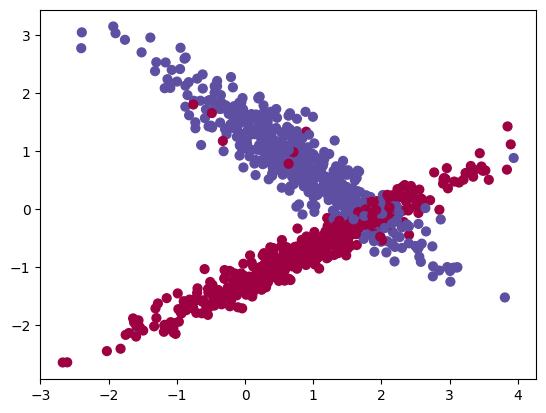

0-th iteration: 0.006477439791109304
1000-th iteration: 0.0021183772617819003
2000-th iteration: 0.001485817571890215
3000-th iteration: 0.0013899151982333002
Early stopping after 3343 epochs.


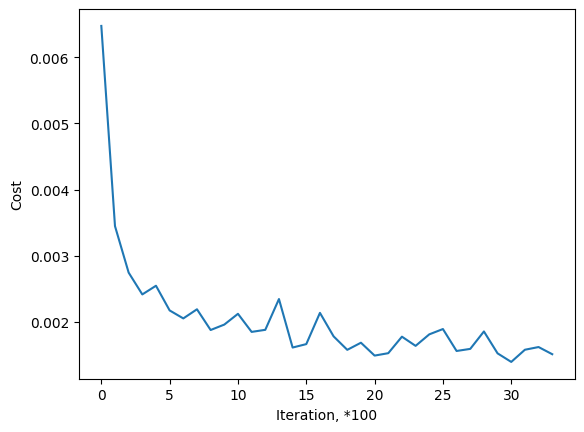

Accuracy: 
0.94
Report: 
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       101
           1       0.93      0.95      0.94        99

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200

Confusion: 
    0   1
0  94   7
1   5  94


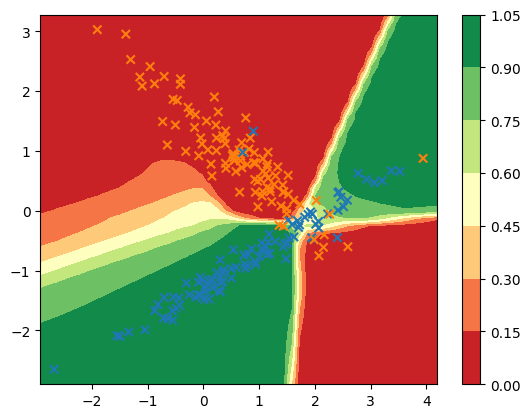

In [186]:
NUM_CLASSES = 2
X, y = make_classification(n_samples = 1000, n_classes = NUM_CLASSES, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8, n_clusters_per_class=1)
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_dims_1 = [X.shape[1], 20, 20, 20, 20, 20, 1]
layer_activations_1 = ['relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_1 = 128
keep_prob_1 = 0.9
patience_1 = 3000

nn = NeuralNet(layer_dims_1, layer_activations_1, mini_batch_size=mini_batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.01, num_epochs=5000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
if layer_dims_1[-1] == 1:
    plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Test Field for Softmax

In [187]:
import os
import tensorflow as tf
from tensorflow import keras

In [188]:
mean = np.mean(X_train)
std = np.std(X_train)

X_train_normalized = (X_train - mean) / std

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=optimizer,                   
                loss='sparse_categorical_crossentropy',                   
                metrics=['accuracy'])

history = model.fit(X_train_normalized, y_train, epochs=300, batch_size=128)

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4839 - loss: 0.6852
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5214 - loss: 0.6833 
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5345 - loss: 0.6824 
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5589 - loss: 0.6785 
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5664 - loss: 0.6764 
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5776 - loss: 0.6767 
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6262 - loss: 0.6711 
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6383 - loss: 0.6715 
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6221 - loss: 0.6691 
Epoch 10/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6442 - loss: 0.6659 
Epoch 11/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6689 - loss: 0.6665 
Epoch 12/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6887 - loss

# Симульовані дані 2

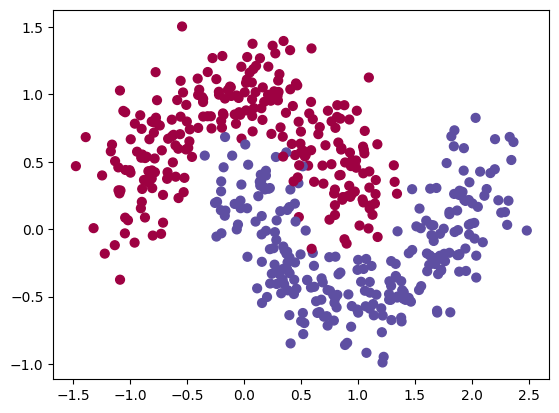

0-th iteration: 0.023185682344905166
1000-th iteration: 0.011004187889846685


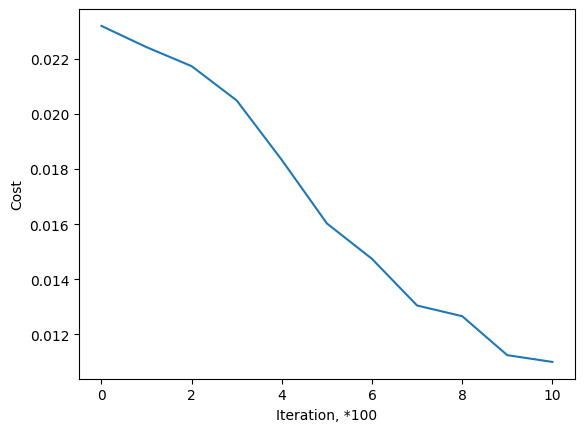

Accuracy: 
0.85
Report: 
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        43
           1       0.94      0.79      0.86        57

    accuracy                           0.85       100
   macro avg       0.85      0.86      0.85       100
weighted avg       0.87      0.85      0.85       100

Confusion: 
    0   1
0  40   3
1  12  45


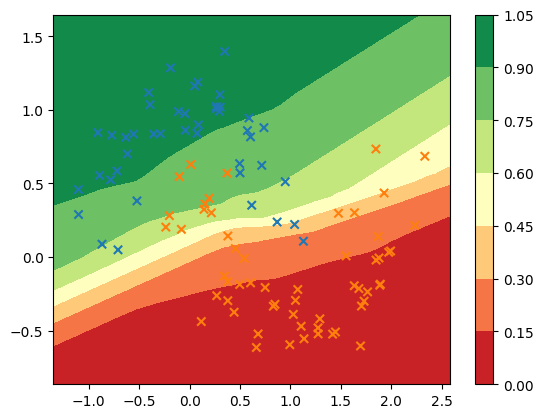

In [189]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_dims_2 = [X.shape[1], 10, 10, 5, LAST_NEURON]
layer_activations_2 = ['relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_2 = 32
keep_prob_2 = 0.9
patience_2 = 2000

nn = NeuralNet(layer_dims_2, layer_activations_2, mini_batch_size=mini_batch_size_2, keep_prob=keep_prob_2, patience=patience_2, learning_rate = 0.001, num_epochs=1000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
if layer_dims_2[-1] == 1:
    plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Tests dataset

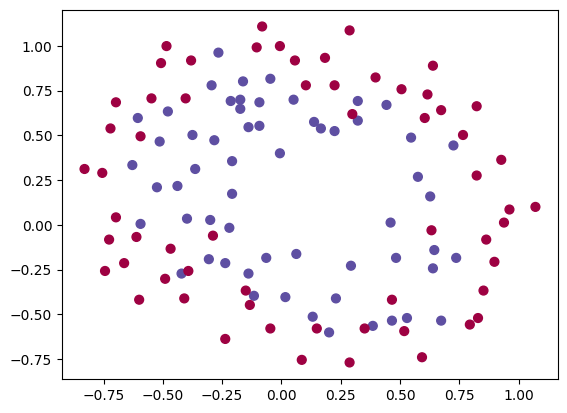

In [190]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column].values
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

0-th iteration: 0.02176795950228564
1000-th iteration: 0.01752542340443183
Early stopping after 1067 epochs.


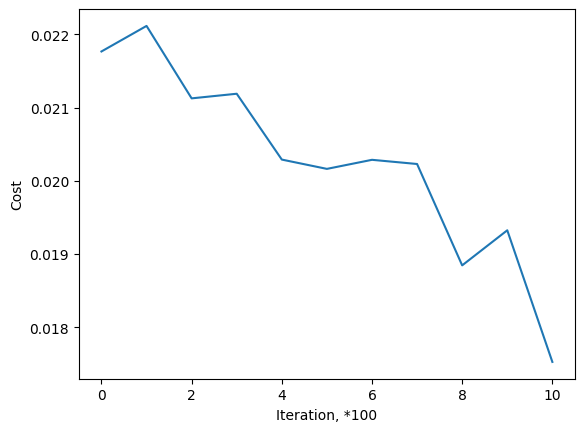

Accuracy: 
0.75
Report: 
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.71      0.83      0.77        12

    accuracy                           0.75        24
   macro avg       0.76      0.75      0.75        24
weighted avg       0.76      0.75      0.75        24

Confusion: 
   0   1
0  8   4
1  2  10


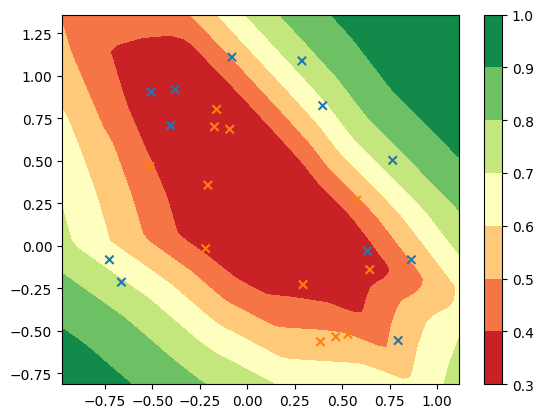

In [191]:
layer_dims_3 = [X.shape[1], 10, 10, 5, LAST_NEURON]
layer_activations_3 = ['relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_3 = 32
keep_prob_3 = 0.9
patience_3 = 500

nn = NeuralNet(layer_dims_3, layer_activations_3, mini_batch_size=mini_batch_size_3, keep_prob=keep_prob_3, patience=patience_3, normalize = True, learning_rate = 0.01, num_epochs=5000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
if layer_dims_3[-1] == 1:
    plot_decision_boundary(nn, X_test, y_test)
plt.show()

In [192]:
print(nn.parameters)

{'W1': array([[ 0.37959899, -0.13827697],
       [ 0.58070832,  1.11321767],
       [-0.14946584, -0.10305062],
       [ 1.10997795,  0.59271401],
       [-0.25520056,  0.18573762],
       [-0.37638712, -0.36488274],
       [ 0.14269439, -1.4164823 ],
       [-1.30691303, -0.30137902],
       [-0.78102597,  0.21924979],
       [-0.65526486, -1.02076915]]), 'b1': array([[-0.10494825],
       [-0.09927403],
       [ 0.01449968],
       [-0.25796114],
       [ 0.08945106],
       [-0.03480003],
       [-0.15559424],
       [-0.09388882],
       [-0.00941864],
       [ 0.00845574]]), 'W2': array([[ 0.45618957, -0.08061237,  0.02085384, -0.45151543, -0.17207397,
         0.03294291, -0.36620509,  0.1181039 , -0.18986298, -0.10182563],
       [-0.18386504,  0.59004835, -0.00461265, -0.31794198,  0.2532429 ,
        -0.3861614 ,  0.07734636, -0.61987345, -0.42074752,  0.06469053],
       [ 0.22932569,  0.04646402, -0.03516872, -0.10050646, -0.46187655,
        -0.22470752, -0.14590722,  0.347

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [193]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

clf.fit(X_train, y_train.ravel())
y_test_pred = clf.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plt.show()

Accuracy: 
0.7916666666666666
Report: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24

Confusion: 
    0  1
0  10  2
1   3  9


In [194]:
clf.n_iter_

1223